(qft)=
## Transformada cuántica de Fourier

```{index} QFT 
```


La transformada cuántica de Fourrier es una herramienta muy utilizada dentro de la programación cuántica, y por eso se ha creído conveniente dedicar un apartado completo a la misma.

Inicialmente esta transformada se define de la siguiente manera. Si tenemos un qubit $|x\rangle$ en la base computacional a la base de Fourier, es decit realiza esta trmasformación:

$$|x\rangle\longrightarrow\frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}e^{2\pi i\frac{x\cdot y}{N}}|y\rangle$$

Esta expresión en principio tan complicada, junto a un análisis pormenorizado de esta transformación , se puede ver su explicación en el siguiente vídeo https://www.youtube.com/watch?v=MiFPhbLw9Aw&t=4s

Como puede verse en dicho vídeo, al final la base de Fourier se construye mediante puerta Hadamard y puerta de rotación U controladas.

El QFT más sencillo es el que se implementa sobre un circuito con un sólo qubit que en este caso no es más que una puerta de Hadamard. Sin embargo, si implementamos un QFT de 2 cubits, entonces necesitamos las puerta U1 controladas:

![](images/QFT.PNG)


Primero implementamos una puerta de Hadamard que pone q0 en superposición. A continuación aplicamos una puerta U1 controlada con una rotación de pi/2 a q1. Después de esto se aplica una puerta de Hadamard a q1. A continuación aplicamos una puerta de intercambio a q0 y q1.


Para codificar valores en N qubits tenemos que duplicar el valor de rotación de cada qubit. Por ejemplo, el siguiente diagrama muestra un QFT de 5 qubits.

Observe cómo para q0 aplica una rotación de pi/2 para q1, luego pi/4 para q2, luego pi/8 para q3 y así sucesivamente. Este patrón se repite para cada qubit. Cuando se han aplicado todas las rotaciones a un qubit, se coloca en superposición mediante una puerta de Hadamard. Luego se puede utilizar como qubit de control para aplicar rotaciones a los qubits objetivo que se encuentran debajo de él.

![](images/QFT_2.PNG)


En la práctica ya existen funciones implementadas tanto en qiskit como en PennyLine para implementar las transformada cuántica de Fourier. En qiskit está en qiskit.circuit.library.QFT y en PennyLine se le puede llamar mediante qml.QFT

Inicialmente vamos a ver cómo implementar todo esto mediante código directo sobre qiskit.


En primer lugar vamos a realizar la siguiente aclaración:  
 Existen muchos libros en los que se trabaja  con el qubit menos significativo abajo del todo. De este modo si teníamos 4 qubits y queríamos poner el número 3, se hae  lo siguiente:

--|0>--  
--|0>--  
--|1>--  
--|1>--  

ya que |0011> es el número 3 en binario. Sin embargo para qiskit o quirk, el qubit menos significativo se encuentra arriba del todo, por lo que si queremos representar el número 3, para qiskit sería:

--|1>--  
--|1>--  
--|0>--  
--|0>--  

Comenzamos importando las librerías necesarias

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_multivector 
from numpy import pi



In [2]:
def QFT(n):
    # n := número de qubits
    
    qft_circ = QuantumCircuit(n,n)
    
    for i in range(n-1, -1, -1): # luego i va de n-1 a 0, restando de uno en uno
        
        qft_circ.h(i) # primero añadimos la puerta H
        
        for j in range(i - 1, -1, -1): 
            # por definir así la j, hacemos el CU1 con todos los qubits que quedan por encima
            
            #primero pasamos el parámetro luego el qubit de control y luego el objetivo
            #qft_circ.cu1(pi/(2 ** (i - j)), j, i)
            # Aplico una puerta CPaseGate
            qft_circ.cp(pi/(2 ** (i - j)), j, i)
    
        qft_circ.barrier(range(n))
        
    for i in range(n // 2): # hacemos el swap final para que queden bien cuadrados
        qft_circ.swap(i, n - i - 1)
        
    return qft_circ

In [3]:
#!pip install pylatexenc

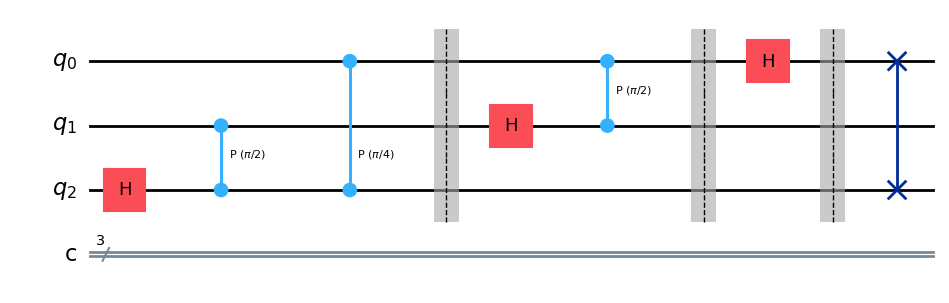

In [4]:
# Representamos en el caso de tener 3 qubits
QFT(3).draw('mpl', style='iqp')

In [5]:
# veamos como se representa el numero 3 cuando tenemos 2 qubits
n = 2
circ = QuantumCircuit(n)

# el numero tres sería |11> , luego creamos esas dos puertas x
circ.x(0)
circ.x(1)

# La instrucción original era
#circ += QFT(n)
# Que daba error pues desde la versión 0.23 el símbolo + se ha cambiado por & ( de compose circuits)
circ &= QFT(n) # añadimos la transformada de Fourier para dos qubits.



Ahora vamos a trabajar con el statevector simulator. Basicamente es un simulador que nos da el vector solución (no colapsará hacia ningún estado). Este simulador solo se suele utilizar para entender lo que está pasando y ver resultados de una forma clara, un computador cuántico nunca nos dará el estado real de un qubit, si no hacia que valor colapsa.

In [6]:
#!pip install qiskit-aer

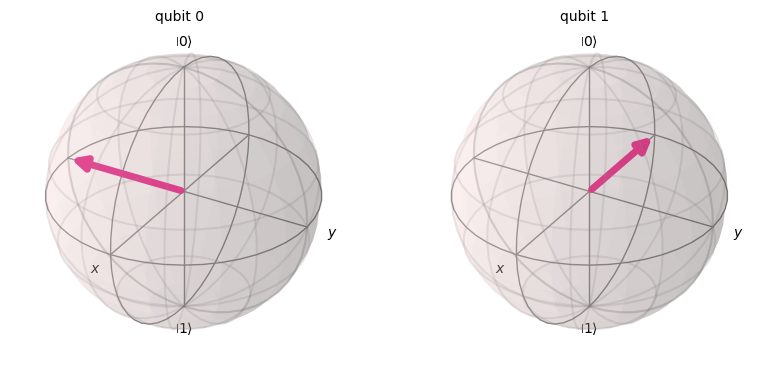

In [9]:
backend = Aer.get_backend("statevector_simulator")
statevector = backend.run(circ, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

Como podeis ver, los resultados son los esperados ya que el primer qubit recorre 3/4 de la circunferencia y el segundo qubit el doble, 6/4 (que eqivale a dar una vuelta y media)

La transformada inversa se sacaría de la misma manera. Tan solo habría que ver que puertas van anulando las de la tranformada normal. Por lo tanto empezaríamos con los swap y luego con rotaciones del mismo ángulo en sentido opuesto.

## QFT en qiskit

Qiskit implementa esta transformada en dentro de la librería *qiskit.circuit.library*, mediante la siguiente instrucción:

> QFT(num_qubits=None, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=False, name=None)

Dónde:

* **num_qubits**: Es el número de qubits qu queremos añadit al QFT.

* **approximation_degree** Nos permite reducir la profundidad del circuito ignorando las rotaciones de fase bajo cierto valor.

* **do_swaps**: si se establece en verdadero, entonces usamos puertas de intercambio en QFT

* **inverse**: si se establece en verdadero, implementamos el QFT inverso

* **insert_barriers**: si se establece en verdadero, insertamos barreras en el circuito

Veamos un pequeño ejemplo con un circuito de 5 qubits

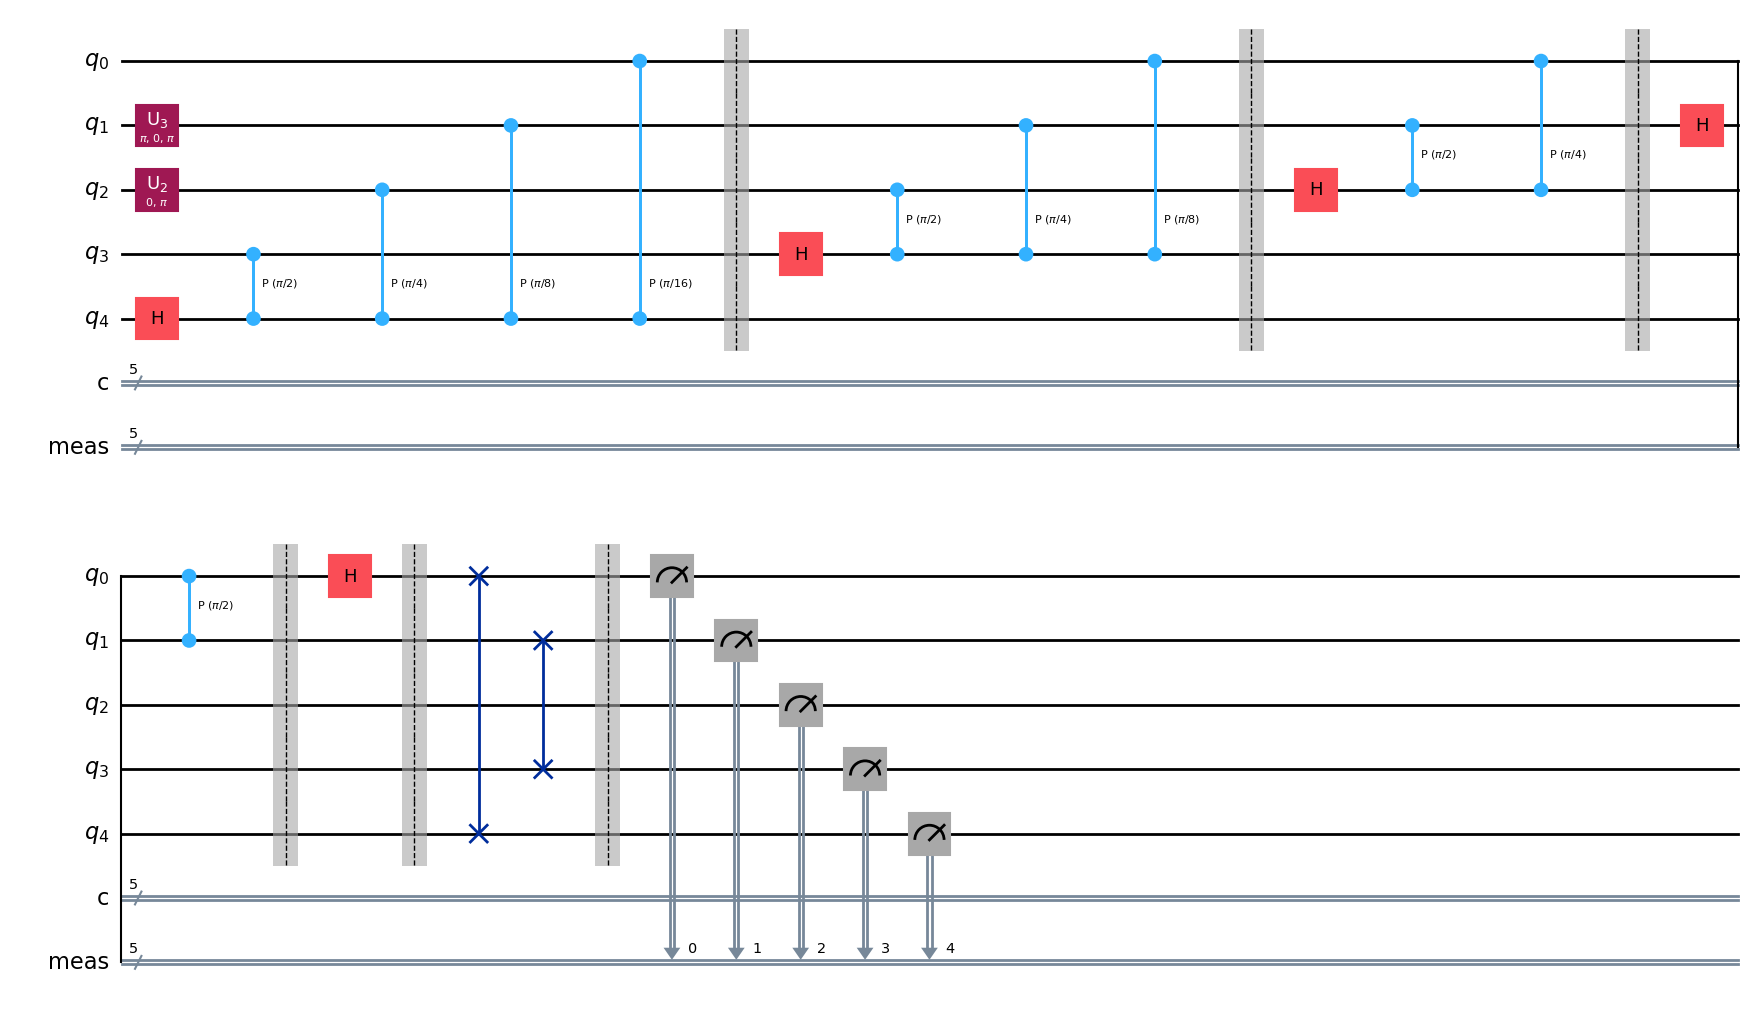

In [8]:
from qiskit.circuit.library import QFT

qft_circ = QuantumCircuit(5,5)

qft_circ.x(1)
qft_circ.h(2)
qft_circ &= QFT(num_qubits=5, approximation_degree=0, do_swaps=True,
                inverse=False, insert_barriers=True, name='qft')
qft_circ.measure_all()

qft_circ.decompose().draw('mpl', style='iqp')
